# Qiskit Function - Practical Application of Handover Iterative VQE (HI-VQE) Chemistry for C=C torsional deformation of $C_{2}H_{4}$

# Table of Contents

* [Overview](#overview)
* [Setup](#setup)
* [Part 1: Introduction to HI-VQE](#part-1-introduction-to-hi-vqe)
    * [Exercise 1](#exercise1)
* [Part 2: Accurate Ground State Energy](#part-2-accurate-ground-state-energy)
    * [Exercise 2](#exercise2)
* [Part 3: Torsional Potential Energy](#part-3-torsional-potential-energy)
    * [Exercise 3](#exercise3)

# Overview

The **Handover Iterative VQE (HI-VQE)** method is designed to efficiently build accurate ground state subspace Hamiltonian to avoid diagonalization of full space Hamiltonian matrix, leveraging significant sparsity of full space Hamiltonian observed in quantum chemistry systems. The handover approach ensure the accurate energy estimation sampled from quantum circuits as important and core states of electronic configurations. The quantum circuit parameters are also iteratively revised to navigate to core states enabling robust and reliable calculations even in the presence of quantum noise. 

This notebook guides you how to utilize HI-VQE Chemistry;you'll learn how the HI-VQE function works with the input parameters and setup to explore its application to chemically intriguing molecules. 

The notebook is structured as follows:

- **Part 1: Introduction to HI-VQE**
    In Part 1, you will learn about the HI-VQE algorithm, covering how it works, what problems it's useful for, and what makes it unique.

- **Part 2: Ground State Energy calculation**  
    In Part 2, you will learn how to use the HI-VQE Chemistry to set up and execute the Quantum Chemistry calculations with the $C_2H_4$ (Ethylene) molecule in a given basis. This section will provide you with hands-on experience for HI-VQE Chemistry, focusing on **energy estimation** based on the subspace obtained from quantum samples and energy obtained from classical solvers as handover process. You will be tasked with tuning parameters to improve the performance of HI-VQE and achieve a closer approximation of the molecule's ground state energy. **Your goal** is to refine the parameters to enhance accuracy while considering noise and other quantum device constraints.

- **Part 3: Torsion Potential Energy calculations**  
    Once you've completed the **Part 2**, you'll move on to calculation of torsional deformation and corresponding energy profile of $C_2H_4$. 
    
    You will be tasked with tuning parameters to improve the performance of HI-VQE and achieve a closer approximation of the molecule's ground state energy and potential energy surface upon torsion deformation .

# Setup

In [1]:
# Install dependencies
%pip install "qc-grader[qiskit,jupyter] @ git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git"
%pip install "qiskit[visualization]" qiskit_ibm_runtime qiskit_ibm_catalog py3Dmol ipywidgets 

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to /tmp/pip-install-7i909ev2/qc-grader_8adddb15ff0740188a55c85990a2492b
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /tmp/pip-install-7i909ev2/qc-grader_8adddb15ff0740188a55c85990a2492b
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit 1d7a6915623b0cfeac4c114391c279e9d98eb7f9
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import qc_grader

print(f"Grader version: {qc_grader.__version__}")

Grader version: 0.22.12


You should have Grader `>=0.22.11`. If you see a lower version, you need to restart your kernel and reinstall the grader.

In [3]:
# Imports

# Import common libraries
import reprlib
import py3Dmol
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

# Import qiskit ecosystems
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_catalog import QiskitFunctionsCatalog

# Grader
from grader import grade_ex1a, grade_ex1b, grade_ex2a, grade_ex2b, grade_ex3
from qc_grader.challenges.qgss_2025 import grade_qunova_function

# Define the function to visualize the geometries
def VISUALIZE_GEOMETRIES(structure_names, xyz_strings):
    mol_selector = widgets.SelectionSlider(
        options=[(name, idx) for idx, name in enumerate(structure_names)],
        description='Geometry:',
        style={'description_width': '150px'},
        layout=widgets.Layout(
            width='500px',
            border='2px solid black',
            padding='10px'
        ),
        continuous_update=False
    )
    output = widgets.Output()
    output.layout = widgets.Layout(
        border='2px solid black', 
        padding='5px', 
        width='500px', height='320px'
    )

    def show_molecule(index):
        with output:
            clear_output(wait=True)
            viewer = py3Dmol.view(width=400, height=300)
            viewer.layout.border = '10px solid black'
            viewer.addModel(xyz_strings[index], 'xyz')
            viewer.setStyle({}, {'stick': {}, 'sphere': {'radius': 0.4}})
            viewer.zoom(2)
            viewer.show()

    def on_value_change(change):
        if change['name'] == 'value' and change['type'] == 'change':
            index = change['new']
            show_molecule(index)

    mol_selector.observe(on_value_change)

    display(mol_selector, output)
    show_molecule(0)

<div class="alert alert-block alert-warning">

**Exclusive Access to Qiskit Functions**

As part of Qiskit Global Summer School (QGSS), participants with a Premium or Flex Plan have limited-time trial access to Qiskit Functions. Access is exclusive and subject to your organization’s administrator approval. Complete [this form](https://airtable.com/appj8IrSNZGz4l4BB/pag8WgWdUr5uSJGZA/form) to request access.

If you encounter the error `QiskitServerlessException: Credentials couldn't be verified`. in the cell below, it means your access to Qiskit Functions is not yet active. Please check back later after your request has been processed.

**Note: Running this lab will consume QPU time from your organization’s account. Estimated QPU usage is provided before each cell that executes on a QPU. Please monitor your usage and consult your organization admin if you’re unsure about your allocated QPU time for QGSS Functions labs.**

</div>

In [8]:
# Load the Qiskit Functions Catalog
your_api_key = "deleteThisAndPasteYourAPIKeyHere"
your_crn = "deleteThisAndPasteYourCRNHere"

catalog = QiskitFunctionsCatalog(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn,
)
# You should see a list of Qiskit Functions available to you
# If you encounter the error `QiskitServerlessException: Credentials couldn't be verified`,
# it means your access is not yet active
catalog.list()

[QiskitFunction(qunova/hivqe-chemistry),
 QiskitFunction(global-data-quantum/quantum-portfolio-optimizer),
 QiskitFunction(algorithmiq/tem),
 QiskitFunction(qedma/qesem),
 QiskitFunction(multiverse/singularity),
 QiskitFunction(q-ctrl/optimization-solver),
 QiskitFunction(colibritd/quick-pde),
 QiskitFunction(q-ctrl/performance-management),
 QiskitFunction(kipu-quantum/iskay-quantum-optimizer)]

<div class="alert alert-block alert-success">
    
<b> Load Qiskit Function</b>

Find the correct function name from the list above, or refer to the [Qiskit Functions Catalog](https://quantum.cloud.ibm.com/functions) to locate the appropriate function name string. The name should follow the format: `"[provider]/[title]"`.

</div>

In [5]:
# Load Qunova HI-VQE function

function_name = "qunova/hivqe-chemistry"  # TODO
function = catalog.load(function_name)

In [6]:
grade_qunova_function(function)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [9]:
# You'll need to specify the credentials when initializing QiskitRuntimeService, if they were not previously saved.
service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn,
)
backend = service.least_busy(operational=True, simulator=False)
backend_name = backend.name
print(f"Using the least busy backend: {backend_name}")

Using the least busy backend: ibm_fez


# Part 1: Introduction to HI-VQE

HI‑VQE (Handover Iterative Variational Quantum Eigensolver) is a hybrid quantum-classical algorithm designed to help solve one of the most important problems in quantum chemistry: finding a chemical system's lowest energy state, which we call the ground state.
This is essential for predicting how molecules behave, how they bond, and how chemical reactions happen. But exactly calculating the ground state is extremely hard for big molecules, because the number of possible ways electrons can arrange themselves (called electron configurations) grows exponentially as systems get larger.

Instead of trying every possible configuration (which would be too slow and costly), HI‑VQE cleverly **focuses only on the important ones**, as only a subset of configurations are crucial for modelling the ground state of many chemical systems. It does this using both classical and quantum computing:

1. Specify the desired chemical system using some chemistry software on a classical computer.

2. Use a quantum computer to generate promising electron configurations, essentially asking the quantum device to identify the subset of configurations that are important for the ground state.

3. Check and filter the sampled configurations using classical tools to remove invalid or unimportant ones.

4. Build a simplified model (a “subspace”) from the best configurations found so far.

5. Solve this simplified problem classically by calculating the energy for just this smaller group of configurations.

6. Repeat the process from Step 2, gradually improving the accuracy by updating the quantum circuit and refining the subspace, until the energy estimate stops changing much.

By focusing on a small number of meaningful configurations, HI‑VQE avoids wasting time and resources on unimportant ones and can handle larger molecules than many other quantum chemistry methods. Users can choose different quantum circuits and tune how the algorithm behaves based on the system they’re studying. Additionally, even though today’s quantum devices are noisy, HI‑VQE is designed to handle errors and still produce useful results.

HI‑VQE differs from other methods through the novel combination of the following techniques:

- **Subspace construction:** It builds and updates a compact “subspace” of only the most relevant configurations.

- **Screening and pruning:** It estimates which configurations matter the most and keeps the "subspace" lean.

- **Hybrid iteration:** It alternates between quantum and classical steps, letting each type of computer do what it’s best at.

- **Configuration expansion:** It can generate new candidate configurations classically, adding variety to the quantum-generated ones.

Once HI‑VQE finishes, you get:

- An approximate ground state wave function,

- The corresponding ground state energy, and

- An estimate of how accurate the result is.

These results are useful for studying chemical systems, mapping potential energy surfaces, and exploring reactions and material behavior.

Define all geometries and reference data for $C_{2}H_{4}$ ground state and torsional deformation to be utilized in the following tasks. In this practice, you can obtain ground state energy using 12 electrons with 12 orbitals to utilize 24 qubits.

In [10]:
rhf_energies = {
    "Optimized geometry":-78.0396545776652,
    "30deg-torsion": -78.0192613144388,
    "45deg-torsion": -77.9941686599885,
    "60deg-torsion": -77.9598374283669,
    "90deg-torsion": -77.8675828498107,
}

exact_energies_24qubits = {
    "Optimized geometry":-78.0788722041575,
    "30deg-torsion": -78.0602772472799,
    "45deg-torsion": -78.03806395985646,
    "60deg-torsion": -78.0094172772050,
    "90deg-torsion": -77.9637383376237,
}

xyz_strings = [
"""6
Optimized geometry
C     -0.000000     0.000000     0.666700
C      0.000000     0.000000    -0.666700
H     -0.000000     0.931265     1.241297
H     -0.000000    -0.931265     1.241297
H     -0.000000    -0.931265    -1.241297
H      0.000000     0.931265    -1.241297""",
"""6
30deg-torsion
C      0.000000    -0.000000     0.670241
C      0.000000    -0.000000    -0.670241
H     -0.240927     0.899153     1.248661
H      0.240927    -0.899153     1.248661
H     -0.240927    -0.899153    -1.248661
H      0.240927     0.899153    -1.248661""",
"""6
45deg-torsion
C      0.000000    -0.000000     0.674960
C      0.000000    -0.000000    -0.674960
H     -0.355980     0.859414     1.257953
H      0.355980    -0.859414     1.257953
H     -0.355980    -0.859414    -1.257953
H      0.355980     0.859414    -1.257953""",
"""6
60deg-torsion
C      0.000000    -0.000000     0.682204
C      0.000000    -0.000000    -0.682204
H     -0.464596     0.804705     1.270962
H      0.464596    -0.804705     1.270962
H     -0.464596    -0.804705    -1.270962
H      0.464596     0.804705    -1.270962""",
"""6
90deg-torsion
C     -0.000000     0.000000     0.708799
C      0.000000     0.000000    -0.708799
H     -0.655845     0.655846     1.306020
H      0.655845    -0.655846     1.306020
H     -0.655845    -0.655846    -1.306020
H      0.655845     0.655846    -1.306020""",
]

structure_names = []
molecular_geometries = []
for xyz_string in xyz_strings:
    structure_name = xyz_string.split("\n")[1]
    structure_names.append(structure_name)
    xyz_data = ";".join(xyz_string.split("\n")[2:])
    molecular_geometries.append(xyz_data)

<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 1:</b> 

Submit the first $C{_2}H{_4}$ geometry for 24 qubits and 12 electrons with `ccpvdz` and obtain ground state energy using HI-VQE Chemistry function. You will use 6 occupied spatial orbitals out of 8 occupied orbitals with 6 virtual spatial orbitals. `active orbital` and `frozen orbital` should be supplied as orbital indices in zero base indexing.

</div>

In [21]:
### Write your code below here ###
molecule_options = {
    "basis": "ccpvdz", # TODO set basis
    "active_orbitals": [2,3,4,5,6,7,8,9,10,11,12,13], # TODO set active orbitals
    "frozen_orbitals": [0,1] # TODO set frozen orbitals
}

### Don't change any code past this line ###

hivqe_options = {"shots": 1000, "max_iter": 40}
max_states = 2000
classical_expansion_states = 10

In [22]:
grade_ex1a(molecule_options)

'Congratulations! 🎉 Your answer is correct.'

<div class="alert alert-block alert-warning">

**⚠️ Warning: QPU Time Consumption**

Running the cell below will submit a job to a QPU and consume real QPU time. Please ensure you intend to proceed.

**Estimated QPU runtime:** 1 minutes 22 seconds (based on tests on `ibm_fez`)

</div>

In [23]:
# Run HI-VQE
job = function.run(
    geometry=molecular_geometries[0],
    backend_name=backend_name,
    max_states=max_states,
    max_expansion_states=classical_expansion_states,
    molecule_options=molecule_options,
    hivqe_options=hivqe_options,
    use_session=True,
)

job_id = job.job_id
job_status = job.status()
print(f"Optimized geometry HI-VQE Job ID: {job_id}, status: {job_status}")

ex1_job_id = {"ex1b_job_id": job_id}

Optimized geometry HI-VQE Job ID: 5042f4b7-bbdd-4304-b845-0f88b98cddf9, status: QUEUED


In [25]:
job_id = ex1_job_id["ex1b_job_id"]
job = catalog.job(job_id)
job_status = job.status()

if job_status == 'DONE':
    job_result = job.result()
    print(f"Optimized geometry HI-VQE energy: {job_result['energy']}")
else:
    print(f"Waiting for job to complete: {job_id}, status: {job_status}")

Optimized geometry HI-VQE energy: -78.07719158939386


In [28]:
# Submit your answer using following code
ex1b_answer = {
    "hivqe_energy": job_result['energy'], # TODO get hivqe energy
}

In [29]:
grade_ex1b(ex1b_answer)

'Congratulations! 🎉 Your answer is correct.'

# Part 2: Accurate Ground State Energy

Ethylene ($C_{2}H_{4}$) is a fundamental molecule in organic and theoretical chemistry. With 16 electrons and a simple planar structure, it provides a clean system to study π-bonding, electronic excitation, and torsional barriers using quantum chemical methods.

Geometry and Bonding

- **Geometry**: Planar molecule with sp² hybridized carbon atoms.
- **Bonding**:
    - Each carbon forms 3 σ-bonds:
        - 2 with hydrogen atoms.
        - 1 with the other carbon atom.
    - The **π bond** between carbons arises from sideways overlap of unhybridized 2p orbitals.
- **Electronic Structure**
    - The π and π* orbitals are well-separated from the σ-framework.
    - Ideal for studying **active space** approaches in multireference methods.
    - The π → π* excitation is a **benchmark** low-lying singlet excited state. This makes ethylene highly valuable for benchmarking excited-state computational methods.

- **Torsional Barrier**
    - Rotation around the C=C bond breaks the π-overlap, creating a **torsional barrier**.
    - Useful for exploring **correlation effects** and **orbital symmetry breaking**.

<a id="exercise2"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 2:</b> 

Submit calculations with several `max_states` value to obtain chemically accurate result (less than 1.6 mHa difference from exact result) and submit the best `max_states` as the answer of the exercise2. Note that you should use the same `molecule_options` obtained from the exercise1.
    
</div>

In [30]:
### Write your code below here ###

max_states_list = [ 2000, 3000, 4000, 5000 ] #TODO use max_states list between 2000 and 5000
molecule_options = {
    "basis": "ccpvdz", # TODO set basis
    "active_orbitals": [2,3,4,5,6,7,8,9,10,11,12,13], # TODO set active orbitals
    "frozen_orbitals": [0,1] # TODO set frozen orbitals
}

In [31]:
ex2a_answer = {
    "max_states_list": max_states_list,
    "basis": molecule_options["basis"],
    "active_orbitals": molecule_options["active_orbitals"],
    "frozen_orbitals": molecule_options["frozen_orbitals"],
}

grade_ex2a(ex2a_answer)

'Congratulations! 🎉 Your answer is correct.'

<div class="alert alert-block alert-warning">

**⚠️ Warning: QPU Time Consumption**

Running the cell below will submit multiple jobs to a QPU and consume real QPU time. Please ensure you intend to proceed.

**Estimated QPU runtime:** 6 minutes 2 seconds (based on tests on `ibm_fez`)


</div>

In [32]:
### Don't change any code past this line ###

ex2_job_ids = {}
for max_states in max_states_list:
    hivqe_options = {"shots": 1000, "max_iter": 40}
    classical_expansion_states = 10
    
    # Run HI-VQE
    job = function.run(
        geometry=molecular_geometries[0],
        backend_name=backend_name,
        max_states=max_states,
        max_expansion_states=classical_expansion_states,
        molecule_options=molecule_options,
        hivqe_options=hivqe_options,
        use_session=True,
    )

    job_id = job.job_id
    ex2_job_ids[max_states] = job_id

<a id="tips"></a>
<div class="alert alert-block alert-info">
    
<b> Tips:</b> 

The `max_states` variable defines the maximum number of states retained in the subspace for diagonalization. It also serves as a threshold for selecting and screening the most relevant states. While smaller values reduce memory usage and computational cost, setting it too low may exclude important states, so it should be chosen carefully based on the problem size and accuracy requirements.

</div>

In [33]:
opt_hivqe_energies = {}

for max_state, job_id in ex2_job_ids.items():
    job = catalog.job(job_id)
    job_status = job.status()
    print(f"Optimized geometry HI-VQE Job ID: {job_id}, status: {job_status}")
    if job_status == 'DONE':
        result = job.result()
        energy = result['energy']
        print(f"HI-VQE energy: {energy}")
        opt_hivqe_energies[max_state]= energy

Optimized geometry HI-VQE Job ID: 73457b6b-ad8e-4fb8-949f-bed140882a56, status: DONE
HI-VQE energy: -78.07719158939386
HI-VQE energy: -78.07719158939386
Optimized geometry HI-VQE Job ID: 352f71e2-67b2-4318-9842-cd34263a9b91, status: DONE
Optimized geometry HI-VQE Job ID: 352f71e2-67b2-4318-9842-cd34263a9b91, status: DONE
HI-VQE energy: -78.07787716315835
HI-VQE energy: -78.07787716315835
Optimized geometry HI-VQE Job ID: c669548b-cbd3-426a-a141-a9955cadff03, status: DONE
Optimized geometry HI-VQE Job ID: c669548b-cbd3-426a-a141-a9955cadff03, status: DONE
HI-VQE energy: -78.07826154274886
HI-VQE energy: -78.07826154274886
Optimized geometry HI-VQE Job ID: cb2104d5-dae5-40d1-bae6-9ca7421909be, status: DONE
Optimized geometry HI-VQE Job ID: cb2104d5-dae5-40d1-bae6-9ca7421909be, status: DONE
HI-VQE energy: -78.07838164300051
HI-VQE energy: -78.07838164300051


All jobs are done


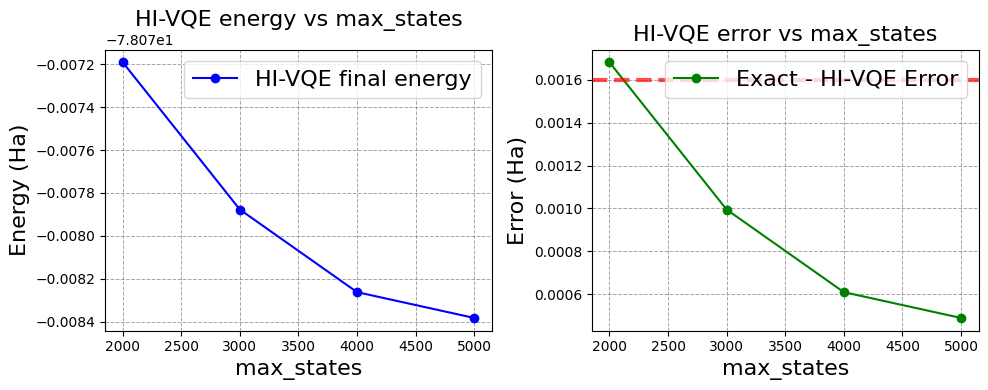

In [34]:
opt_hivqe_energy_values = list(opt_hivqe_energies.values())

if len(ex2_job_ids) == len(opt_hivqe_energies):
    print("All jobs are done")
    # Plot results for the optimized geometry
    rhf_energy = rhf_energies["Optimized geometry"]
    exact_energy = exact_energies_24qubits["Optimized geometry"]
    fig,axs = plt.subplots(1,2,figsize=(10, 4))

    axs[0].plot(max_states_list, opt_hivqe_energy_values, 'o-', label='HI-VQE final energy', color='blue')
    axs[0].set_xlabel('max_states', fontsize=16)
    axs[0].set_ylabel('Energy (Ha)', fontsize=16)
    axs[0].set_title('HI-VQE energy vs max_states', fontsize=16)
    axs[0].legend(fontsize=16)
    axs[0].grid(color='gray', linestyle='--', linewidth=0.7, alpha=0.7)

    axs[1].plot(max_states_list, np.array(opt_hivqe_energy_values)-exact_energy, 'o-', label='Exact - HI-VQE Error', color='green')
    axs[1].set_xlabel('max_states', fontsize=16)
    axs[1].set_ylabel('Error (Ha)', fontsize=16)
    axs[1].set_title('HI-VQE error vs max_states', fontsize=16)
    axs[1].axhline(y=0.0016, color='red', linestyle='--', linewidth=3.0, alpha=0.7)
    axs[1].legend(fontsize=16)
    plt.tight_layout()
    plt.grid(color='gray', linestyle='--', linewidth=0.7, alpha=0.7)
    plt.show()

In [38]:
# Submit your answer using following code
ex2b_answer = {
    "max_states": 5000, #TODO set max_states
    "hivqe_energy": -78.07838164300051 #TODO set hivqe energy
}

In [39]:
# grader set up
grade_ex2b(ex2b_answer)

'Congratulations! 🎉 Your answer is correct.'

# Part 3: Torsional Potential Energy

### What is the torsional potential energy surface (PES) 

The torsional PES of ethylene serves as a textbook example of π-bonding and conjugation effects in unsaturated hydrocarbons. The following image shows that in the 0° conformation, the p-orbitals on each carbon overlap maximally, forming a strong π bond. Upon 90° rotation, the p-orbitals become orthogonal, and the overlap vanishes, effectively breaking the π bond. This results in a significant energy barrier, which is clearly seen on the torsional PES.

Accurately predicting the torsional PES of simple systems like ethylene also holds significant industrial value, as it lays the groundwork for:


- **Polymer and material design:** Ethylene is the monomeric unit of polyethylene. Understanding the torsional behavior informs flexibility, crystallinity, and thermal properties of the polymer chains.
- **Catalysis and reaction mechanisms:** Ethylene is a key feedstock in petrochemical industries. In transition metal catalysis, such as Ziegler–Natta or metallocene catalysts, the ability of ethylene to rotate (or resist rotation) upon coordination impacts the stereochemistry and activity of the polymerization reaction.
- **Surface chemistry and adsorption modeling:** In catalysis on metal surfaces or zeolites, ethylene’s torsion affects how it binds and reacts. Accurate PES modeling is vital in surface science and heterogeneous catalysis.

![Alt text](slide1.png)

Examine the molecular geometry with torsion of C=C bond

In [40]:
VISUALIZE_GEOMETRIES(structure_names, xyz_strings)

SelectionSlider(continuous_update=False, description='Geometry:', layout=Layout(border_bottom='2px solid black…

Output(layout=Layout(border_bottom='2px solid black', border_left='2px solid black', border_right='2px solid b…

<a id="exercise3"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 3:</b> 

Apply max_states value to obtain from the previous HI-VQE exercise calculation and run with 5 different molecular geometry calculations to get torsional deformation PES curve for C=C of $C_{2}H_{4}$
    
</div>

In [49]:
### Write your code below here ###

max_states = 5000 #TODO set max_states
molecule_options = {
    "basis": "ccpvdz", #TODO set basis
    "active_orbitals": [2,3,4,5,6,7,8,9,10,11,12,13], #TODO set active orbitals
    "frozen_orbitals": [0,1] #TODO set frozen orbitals
}

<div class="alert alert-block alert-warning">

**⚠️ Warning: QPU Time Consumption**

Running the cell below will submit multiple jobs to a QPU and consume real QPU time. Please ensure you intend to proceed.

**Estimated QPU runtime:** 5 minutes 50 seconds (based on tests on `ibm_fez`)


</div>

In [50]:
### Don't change any code past this line ###
classical_expansion_states = 10

ex3_job_ids = {}
for structure_name, molecular_geometry in zip(structure_names, molecular_geometries):
    
    hivqe_options = {"shots": 1000, "max_iter": 40}

    # Run HI-VQE
    job = function.run(
        geometry=molecular_geometry,
        backend_name=backend_name,
        max_states=max_states,
        max_expansion_states=classical_expansion_states,
        molecule_options=molecule_options,
        hivqe_options=hivqe_options,
        use_session=True,
    )
    print(f"{structure_name} HI-VQE Job id: {job.job_id} and status: {job.status()}")
    ex3_job_ids[structure_name] = job.job_id

Optimized geometry HI-VQE Job id: d83fa32e-7472-44b4-9f06-7a6f9649be73 and status: QUEUED
30deg-torsion HI-VQE Job id: a533c25a-93ac-4d27-b978-5c2483001b67 and status: QUEUED
30deg-torsion HI-VQE Job id: a533c25a-93ac-4d27-b978-5c2483001b67 and status: QUEUED
45deg-torsion HI-VQE Job id: ab666cd3-69dc-476c-8f94-e24eab293bcd and status: QUEUED
45deg-torsion HI-VQE Job id: ab666cd3-69dc-476c-8f94-e24eab293bcd and status: QUEUED
60deg-torsion HI-VQE Job id: 9b399325-215c-45cf-b48f-ef2d17bc4a5e and status: QUEUED
60deg-torsion HI-VQE Job id: 9b399325-215c-45cf-b48f-ef2d17bc4a5e and status: QUEUED
90deg-torsion HI-VQE Job id: f975dfba-370a-49f6-b1b1-0f25c5ea1cea and status: QUEUED
90deg-torsion HI-VQE Job id: f975dfba-370a-49f6-b1b1-0f25c5ea1cea and status: QUEUED


In [57]:
hivqe_energies_24qubits = {}

for structure_name, job_id in ex3_job_ids.items():
    job = catalog.job(job_id)
    job_status = job.status()
    print(f"{structure_name} HI-VQE Job status:", job_status)
    if job_status == 'DONE':
        result = job.result()
        energy = result['energy']
        print(f"HI-VQE energy: {energy}")
        hivqe_energies_24qubits[structure_name]= energy
    elif job_status == 'ERROR':
        print(f"Job {job_id} failed with error: {job.error_message()}")

Optimized geometry HI-VQE Job status: DONE
HI-VQE energy: -78.07838248236206
HI-VQE energy: -78.07838248236206
30deg-torsion HI-VQE Job status: DONE
30deg-torsion HI-VQE Job status: DONE
HI-VQE energy: -78.05949927311286
HI-VQE energy: -78.05949927311286
45deg-torsion HI-VQE Job status: DONE
45deg-torsion HI-VQE Job status: DONE
HI-VQE energy: -78.03719065683171
HI-VQE energy: -78.03719065683171
60deg-torsion HI-VQE Job status: DONE
60deg-torsion HI-VQE Job status: DONE
HI-VQE energy: -78.00834811284003
HI-VQE energy: -78.00834811284003
90deg-torsion HI-VQE Job status: DONE
90deg-torsion HI-VQE Job status: DONE
HI-VQE energy: -77.96175346370589
HI-VQE energy: -77.96175346370589


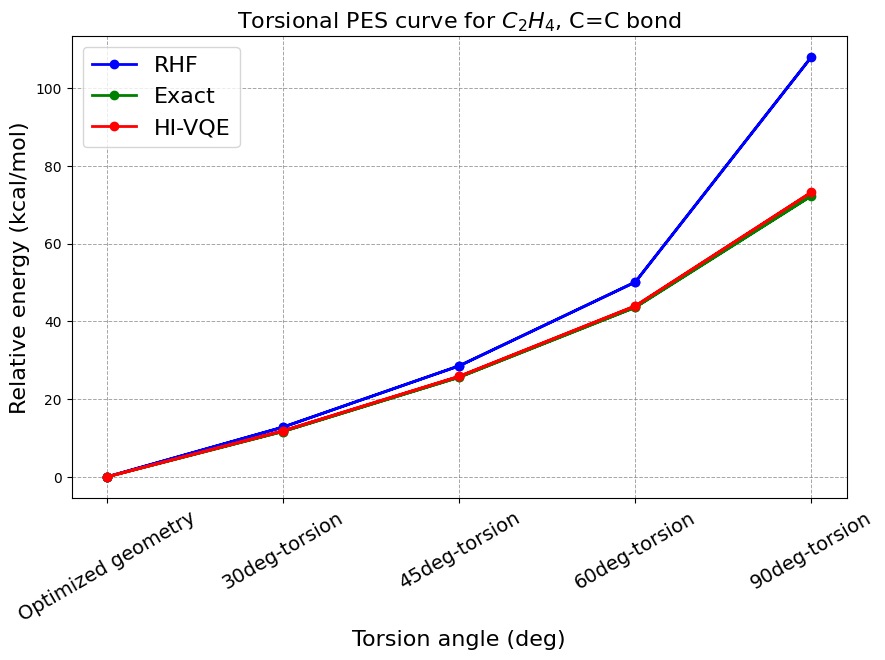

In [58]:

rhf_energy_min = min([v for k,v in rhf_energies.items()])
rhf_energy_rel = np.array([v for k,v in rhf_energies.items()]) - rhf_energy_min
rhf_energy_rel_kcalmol = rhf_energy_rel * 627.509

exact_energies_24qubits_min = min([v for k,v in exact_energies_24qubits.items()])
exact_energies_24qubits_rel = np.array([v for k,v in exact_energies_24qubits.items()]) - exact_energies_24qubits_min
exact_energies_24qubits_rel_kcalmol = exact_energies_24qubits_rel * 627.509

num_hivqe_energies = len([v for k,v in hivqe_energies_24qubits.items()])
num_rhf_energies = len([v for k,v in rhf_energies.items()])
num_exact_energies = len([v for k,v in exact_energies_24qubits.items()])

if num_hivqe_energies == num_exact_energies:
    hivqe_energies_24qubits_min = min([v for k,v in hivqe_energies_24qubits.items()])
    hivqe_energies_24qubits_rel = np.array([v for k,v in hivqe_energies_24qubits.items()]) - hivqe_energies_24qubits_min
    hivqe_energies_24qubits_rel_kcalmol = hivqe_energies_24qubits_rel * 627.509
else:
    print("Error: Number of structures in hivqe_energies_24qubits and rhf_energies do not match")
    
structure_names_symmetric = structure_names + structure_names[-2::-1]
rhf_energy_symmetric = np.concatenate([rhf_energy_rel_kcalmol, rhf_energy_rel_kcalmol[-2::-1]])
exact_energy_symmetric = np.concatenate([exact_energies_24qubits_rel_kcalmol, exact_energies_24qubits_rel_kcalmol[-2::-1]])
if num_hivqe_energies == num_exact_energies:
    hivqe_energy_symmetric = np.concatenate([hivqe_energies_24qubits_rel_kcalmol, hivqe_energies_24qubits_rel_kcalmol[-2::-1]])

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(structure_names_symmetric, rhf_energy_symmetric, 'o-', label="RHF", color="blue", linewidth=2)
plt.plot(structure_names_symmetric, exact_energy_symmetric, 'o-', label="Exact", color="green", linewidth=2)
if num_hivqe_energies == num_exact_energies:
    plt.plot(structure_names_symmetric, hivqe_energy_symmetric, 'o-', label="HI-VQE", color="red", linewidth=2)

plt.xlabel("Torsion angle (deg)", fontsize=16)
plt.ylabel("Relative energy (kcal/mol)", fontsize=16)
plt.title("Torsional PES curve for $C_{2}H_{4}$, C=C bond",fontsize=16)
plt.xticks(rotation=30, fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.7, alpha=0.7)  # Add this line
plt.legend(fontsize=16)
plt.savefig("Torsional_PES_curve_C2H4_C=C_bond.png", dpi=300, bbox_inches="tight")
plt.show()

In [73]:
# Submit your answer using following code

hivqe_energies_24qubits = {
    "Optimized geometry": -78.07838248236206,
    "30deg-torsion": -78.05949927311286,
    "45deg-torsion": -78.03719065683171,
    "60deg-torsion": -78.00834811284003,
    # "90deg-torsion": -77.96175346370589
} #TODO provide above results for hivqe energies in dictionary format

en_diff = []
for k,v in hivqe_energies_24qubits.items():
    en_diff.append(v-exact_energies_24qubits[k])
max_en_diff = max(en_diff)

ex3_answer = max_en_diff

In [74]:
grade_ex3(ex3_answer)

Note: Maximum energy difference is: 1.069164364977837 mHa


'Congratulations! 🎉 Your answer is correct.'

<a id="tips"></a>
<div class="alert alert-block alert-info">
    
<b> Tips:</b> 

You may notice that the solution to Exercise 2 can be directly leveraged to address Exercise 3, even when the system involves inaccuracies in torsional geometry. This is because changes in molecular geometry lead to variations in correlation energies, which in turn require different values for `max_state`. The `max_state` parameter in HI-VQE limits the size of the subspace matrix, enabling efficient selection of the most relevant states from the full Hilbert space. However, it is not intended to be fixed across all systems. Therefore, the convergence tests performed with various `max_state` values in Exercise 2 provide valuable insight for tackling new chemical systems, helping ensure accurate results despite geometric perturbations.
    
</div>

# Feedback Survey

We’d love to hear about your experience using the Qiskit Function! Your feedback is valuable and will help Qiskit Function providers enhance their tools and services. Please take a moment to share your thoughts by completing our short 2 min [feedback survey](https://airtable.com/app6VujlNUHZuOnAF/pagpw6TgP9UEt4TAT/form).

# References

1. HI-VQE Chemistry Qiskit Function Tutorial: https://docs.quantum.ibm.com/guides/qunova-chemistry
2. Arxiv paper describing HI-VQE function: https://arxiv.org/abs/2503.06292

# Additional information

**Created by:** Pilsun Yoo

**Advised by:** Junye Huang

**Version:** 1.1.0

# Qiskit packages versions

In [75]:
import qiskit
import qiskit_ibm_runtime
import qiskit_ibm_catalog

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')
print(f'Qiskit IBM Catalog: {qiskit_ibm_catalog.__version__}')

Qiskit: 2.1.1
Qiskit IBM Runtime: 0.40.1
Qiskit IBM Catalog: 0.8.0
